In [1]:
library("car")
data("Leinhardt")
head(Leinhardt)

,income,infant,region,oil
Australia,3426,26.7,Asia,no
Austria,3350,23.7,Europe,no
Belgium,3346,17.0,Europe,no
Canada,4751,16.8,Americas,no
Denmark,5029,13.5,Europe,no
Finland,3312,10.1,Europe,no


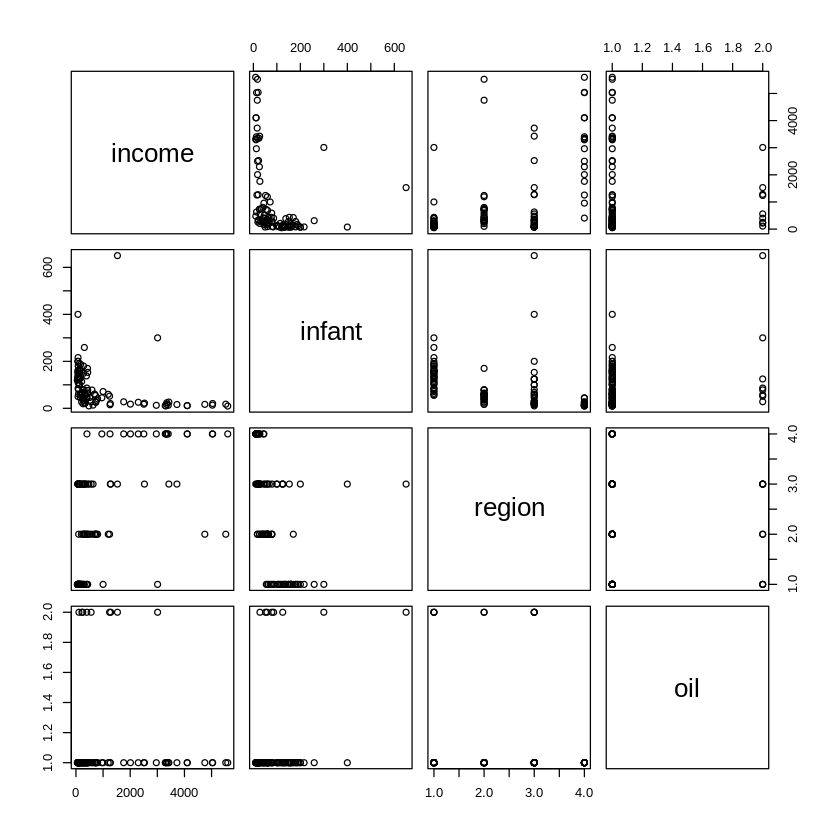

In [2]:
pairs(Leinhardt)

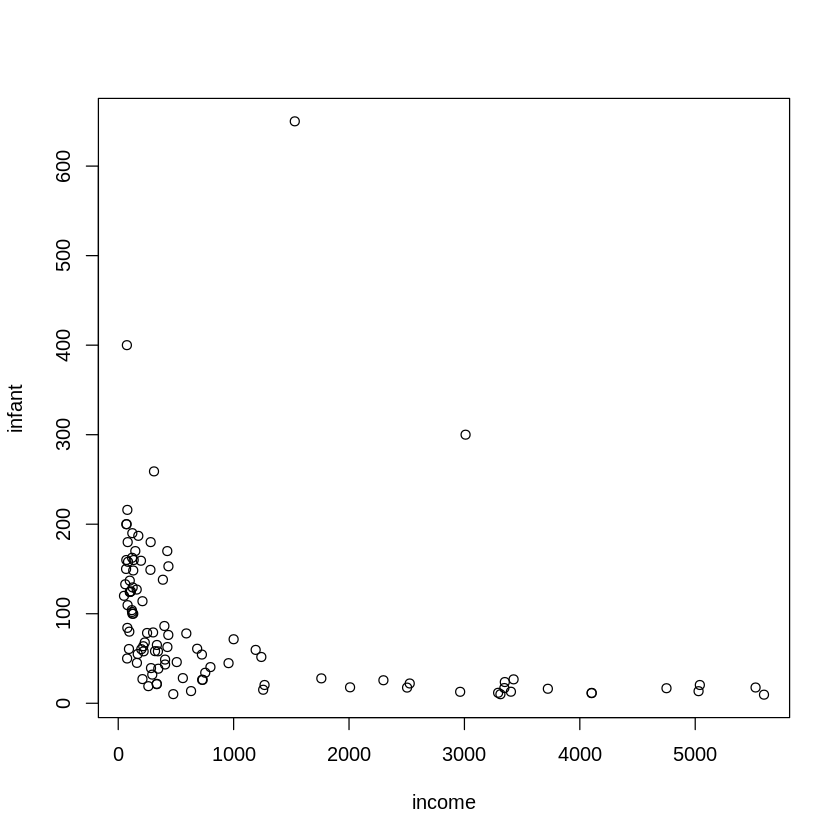

In [4]:
plot(infant ~ income, data = Leinhardt)

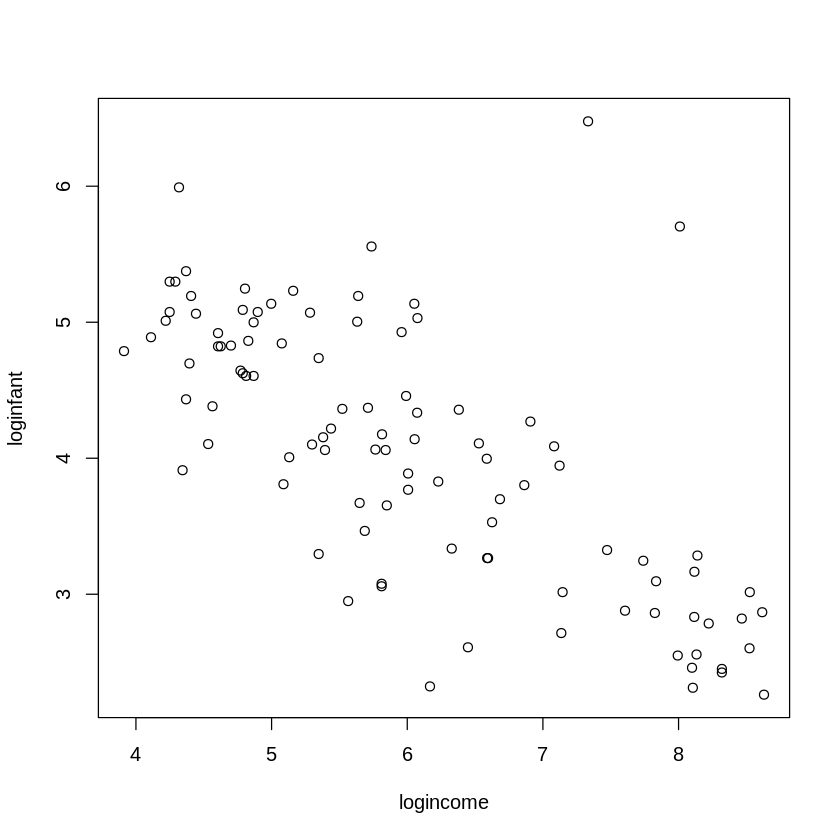

In [6]:
Leinhardt$loginfant = log(Leinhardt$infant)
Leinhardt$logincome = log(Leinhardt$income)
plot(loginfant ~ logincome, data = Leinhardt)

In [7]:
lmod = lm(loginfant ~ logincome, data = Leinhardt)
summary(lmod)


Call:
lm(formula = loginfant ~ logincome, data = Leinhardt)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.66694 -0.42779 -0.02649  0.30441  3.08415 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.14582    0.31654  22.575   <2e-16 ***
logincome   -0.51179    0.05122  -9.992   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6867 on 99 degrees of freedom
  (4 observations deleted due to missingness)
Multiple R-squared:  0.5021,	Adjusted R-squared:  0.4971 
F-statistic: 99.84 on 1 and 99 DF,  p-value: < 2.2e-16


In [9]:
dat = na.omit(Leinhardt)
library("rjags")

Loading required package: coda
Linked to JAGS 4.1.0
Loaded modules: basemod,bugs


In [17]:
mod1_str = "model {
    for (i in 1: n) {
        y[i] ~ dnorm(mu[i], prec)
        mu[i] = b[1] + b[2] * log_income[i]        
    }
    
    for (i in 1:2) {
        b[i] ~ dnorm(0.0, 1./1.e6)        
    }
    
    prec ~ dgamma(5/2.0, 5*10/2.0)
    sig2 = 1 / prec
    sig = sqrt(sig2)
}"

set.seed(42)
data1_jags = list(y=dat$loginfant, n=nrow(dat), log_income=dat$logincome)
params1 = c("b", "sig")

inits1 = function() { 
    inits = list("b" = rnorm(2, 0.0, 100.), "prec"=rgamma(1, 1.0, 1.0))
}

mod1 = jags.model(textConnection(mod1_str), data = data1_jags, inits = inits1, n.chains = 3)
update(mod1, 1000) # burn in

mod1_sim = coda.samples(model = mod1, variable.names = params1, n.iter = 5000)
mod1_csim = do.call(rbind, mod1_sim)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 101
   Unobserved stochastic nodes: 3
   Total graph size: 411

Initializing model



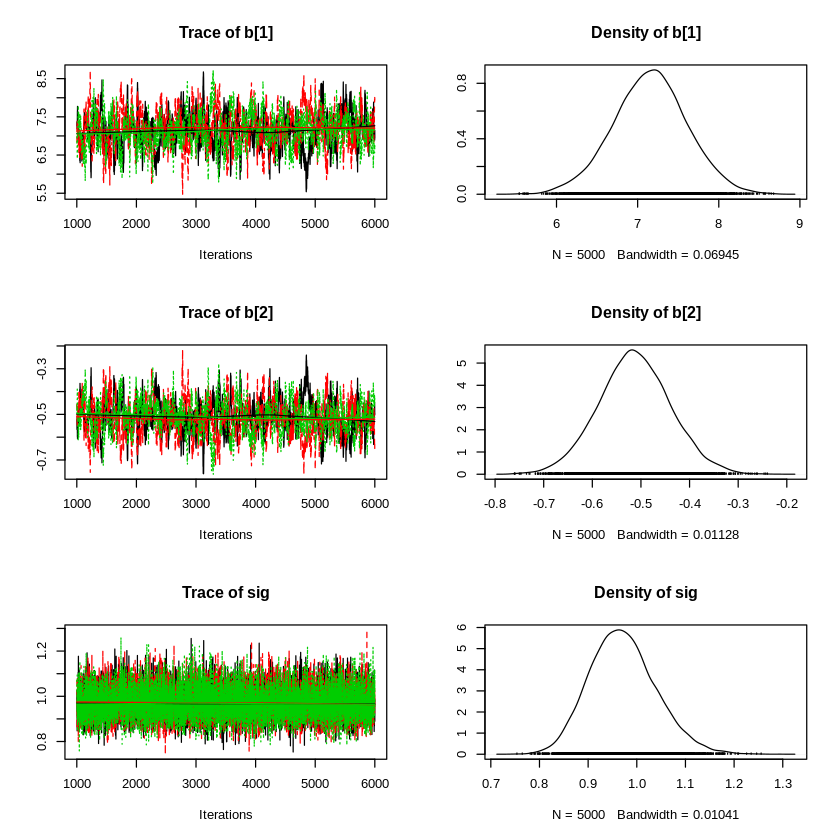

In [22]:
plot(mod1_sim)

In [24]:
?gelman.diag

In [23]:
gelman.diag(mod1_sim)

Potential scale reduction factors:

     Point est. Upper C.I.
b[1]       1.01       1.03
b[2]       1.01       1.03
sig        1.00       1.00

Multivariate psrf

1.01

In [25]:
autocorr.diag(mod1_sim)

,b[1],b[2],sig
Lag 0,1.00000000,1.00000000,1.0000000000
Lag 1,0.95318793,0.95311137,0.0214418809
Lag 5,0.77248034,0.77362742,-0.0009005582
Lag 10,0.58798583,0.58773179,-0.0031666921
Lag 50,0.06126354,0.06060991,-0.0057273363


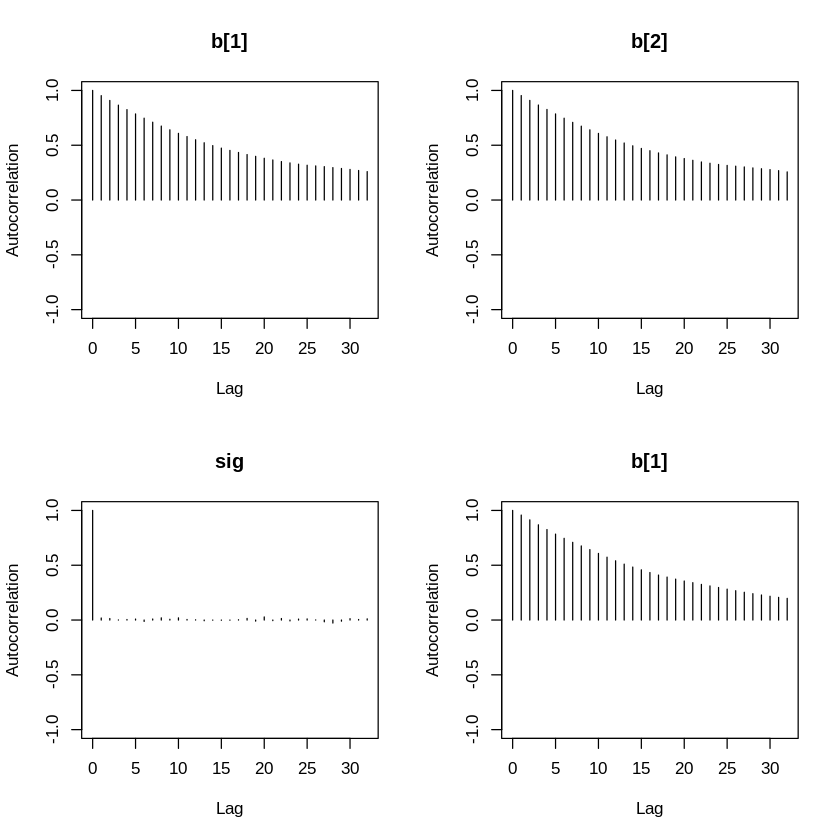

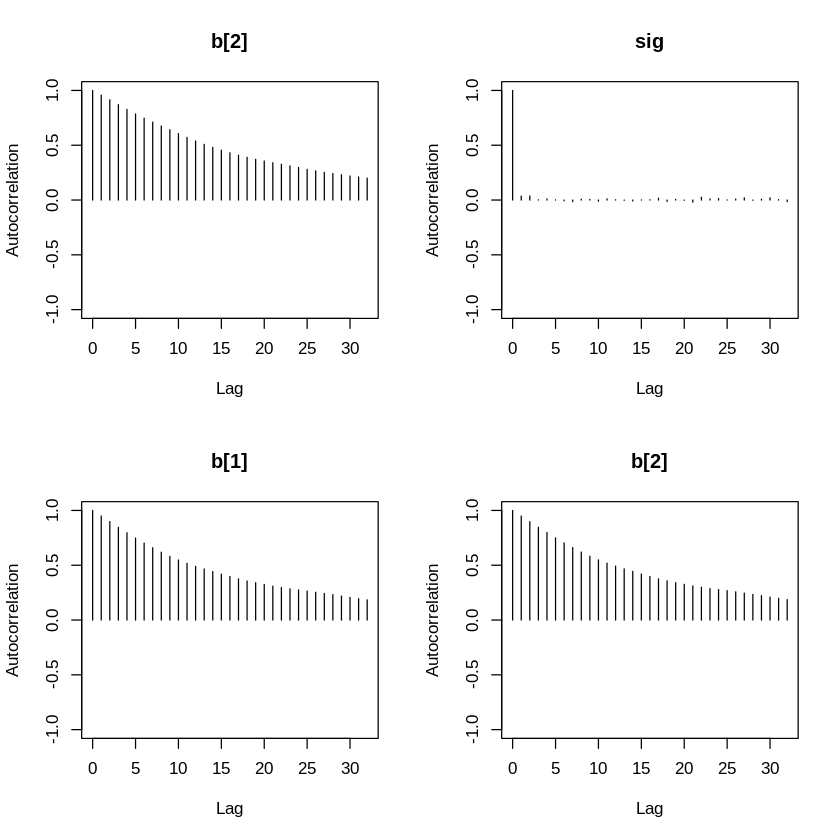

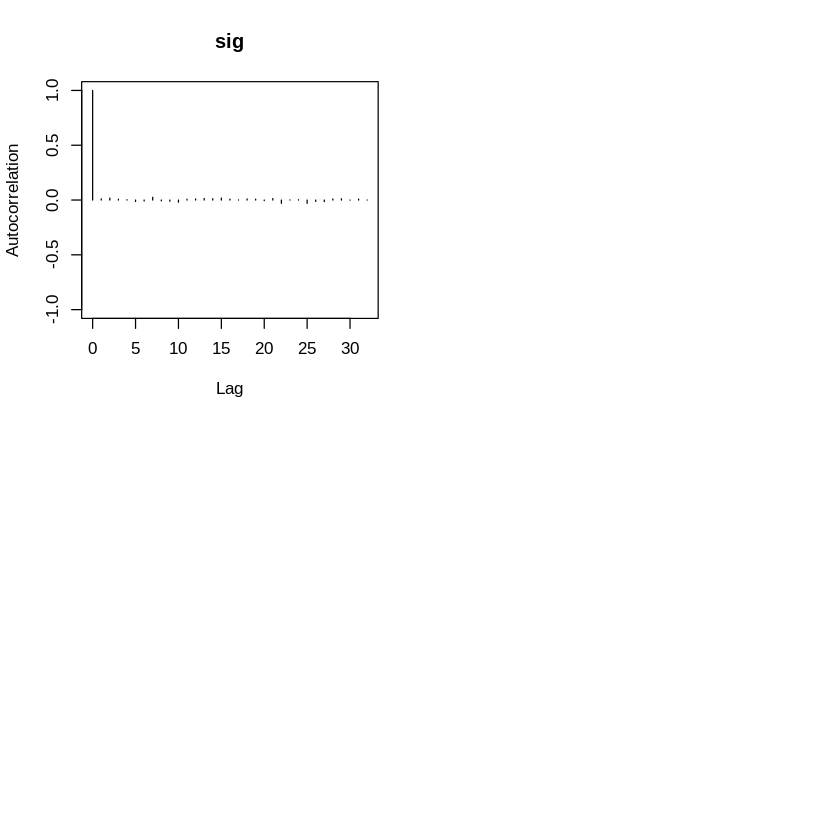

In [26]:
autocorr.plot(mod1_sim)

In [27]:
effectiveSize(mod1_sim)

b[1]       b[2]        sig 
  396.2737   383.9265 14333.6343

## Residuals checks

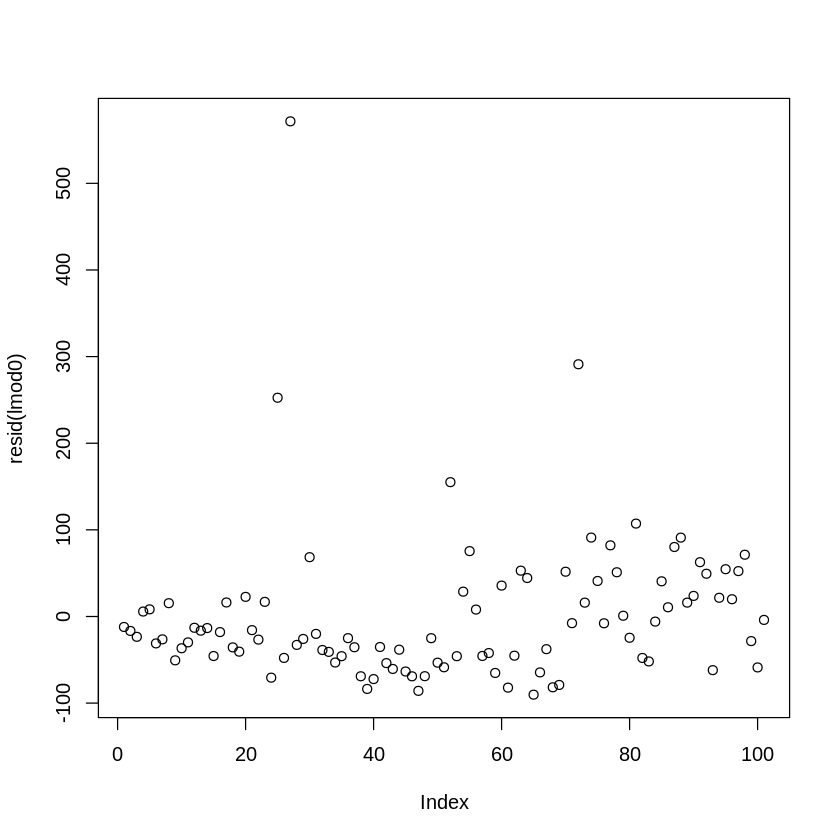

In [28]:
lmod0 = lm(infant ~ income, data=Leinhardt)
plot(resid(lmod0)) # to check independence (looks okay

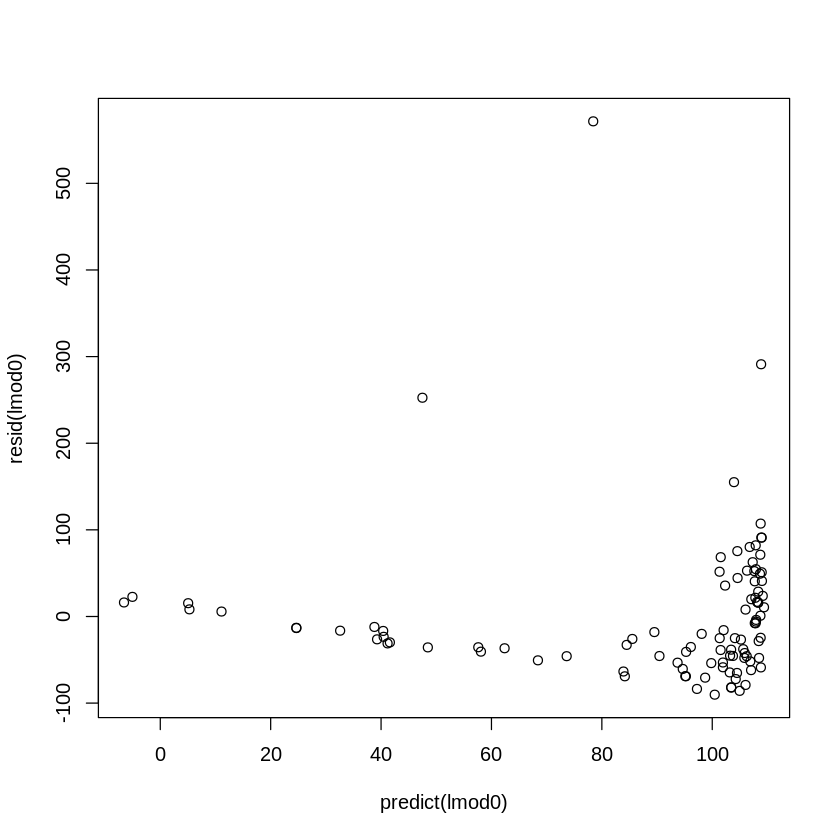

In [29]:
plot(predict(lmod0), resid(lmod0)) # to check for linearity, constant variance (looks bad)

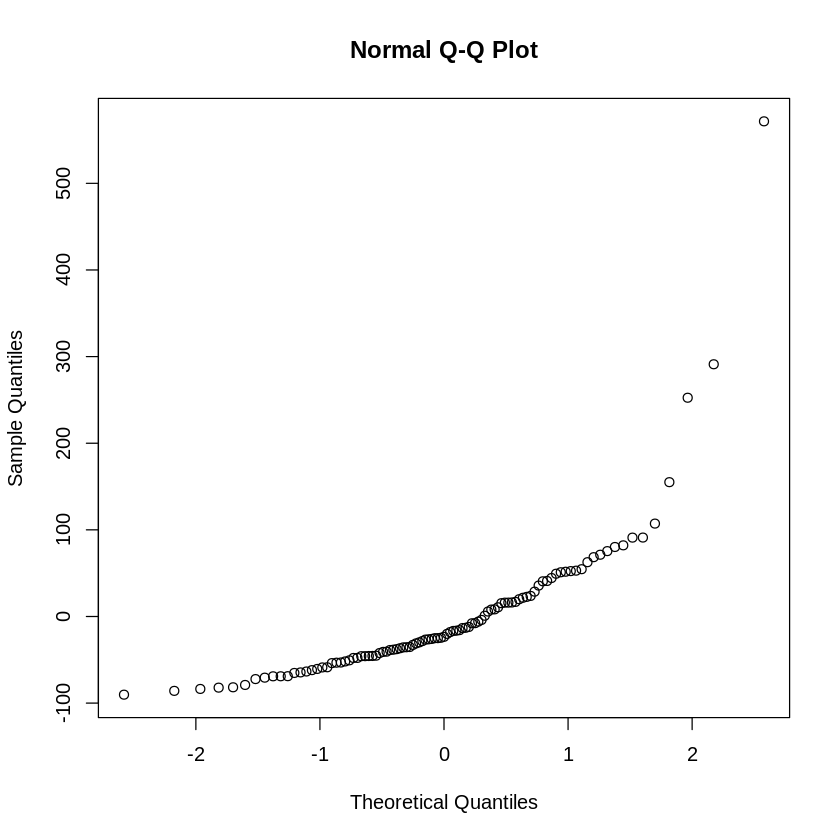

In [30]:
qqnorm(resid(lmod0)) # to check Normality assumption (we want this to be a straight line)

## Bayesian residuals

In [34]:
X = cbind(rep(1.0, data1_jags$n), data1_jags$log_income)
head(X)

1,8.139149
1,8.116716
1,8.115521
1,8.466110
1,8.522976
1,8.105308


In [40]:
pm_params1 = colMeans(mod1_csim)

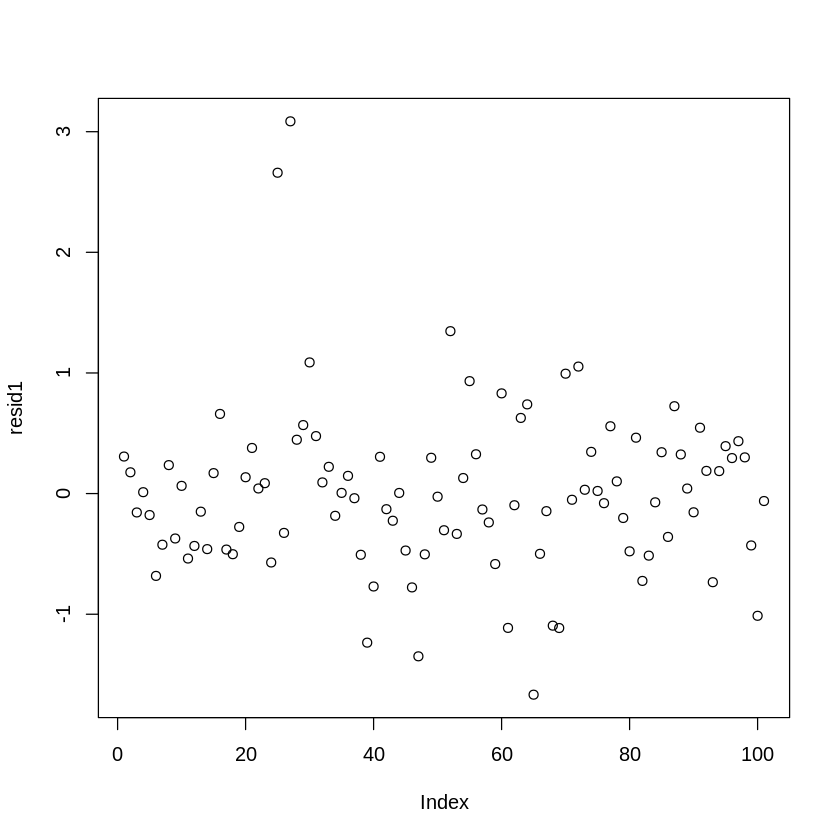

In [47]:
yhat1 = drop(X %*% pm_params1[1:2]) # drop makes an array
resid1 = data1_jags$y - yhat1
plot(resid1)

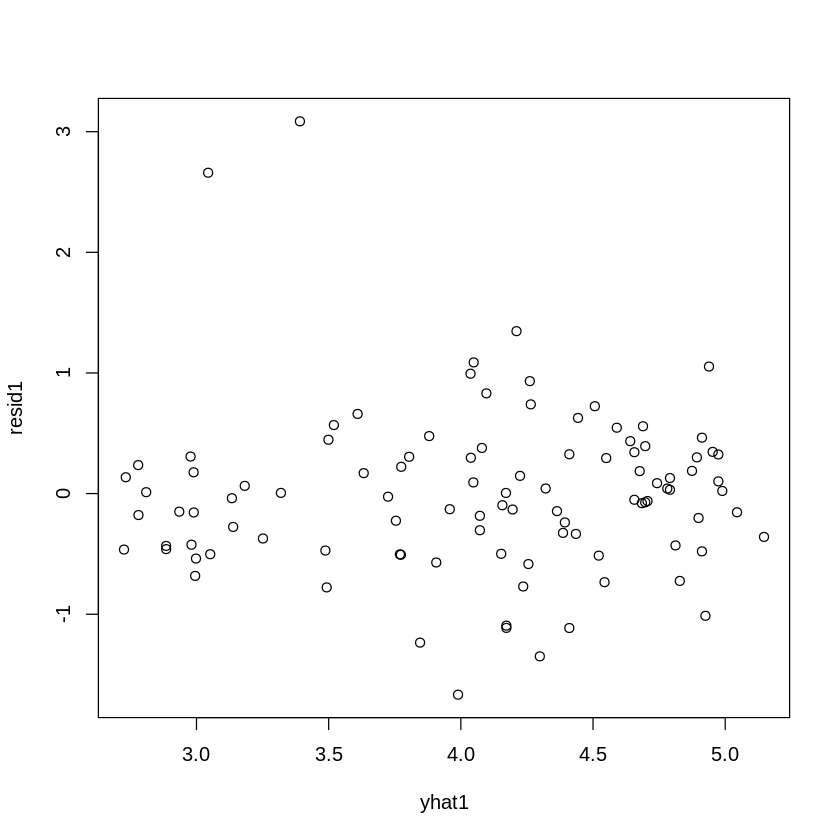

In [49]:
plot(yhat1, resid1)

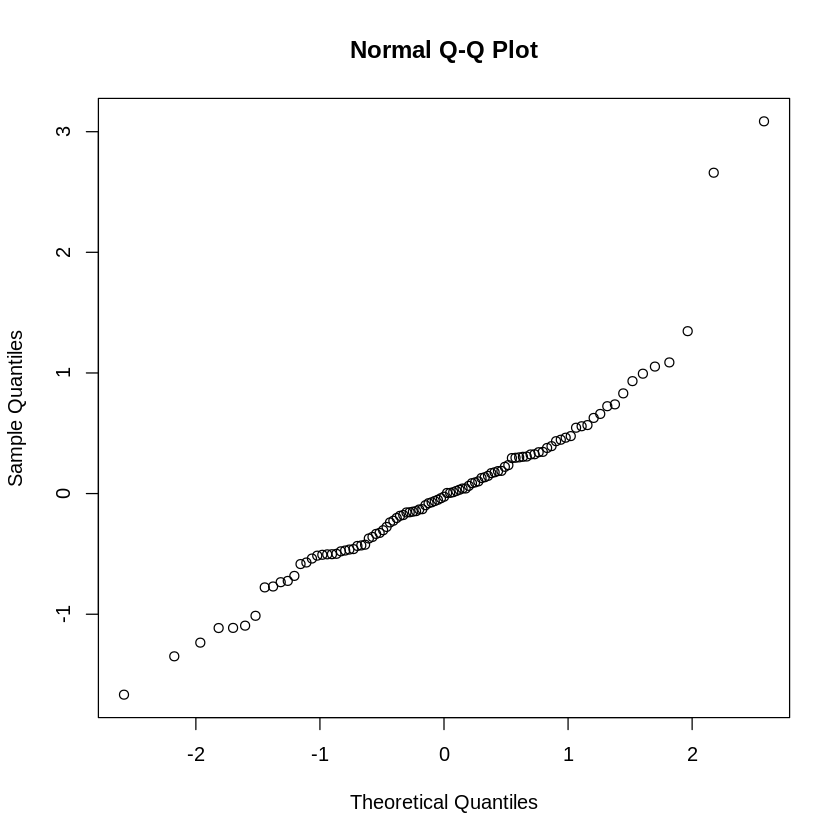

In [50]:
qqnorm(resid1)

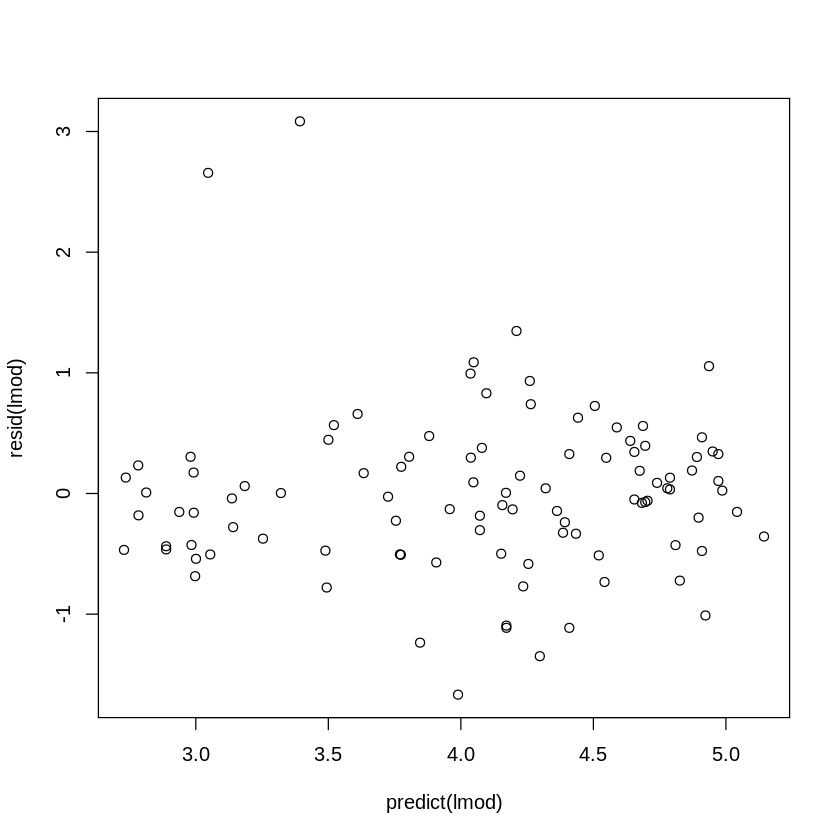

In [51]:
plot(predict(lmod), resid(lmod))

## Adding additional covariates

In [52]:
library("rjags")

mod2_string = " model {
    for (i in 1:length(y)) {
        y[i] ~ dnorm(mu[i], prec)
        mu[i] = b[1] + b[2]*log_income[i] + b[3]*is_oil[i]
    }
    
    for (i in 1:3) {
        b[i] ~ dnorm(0.0, 1.0/1.0e6)
    }
    
    prec ~ dgamma(5/2.0, 5*10.0/2.0)
    sig = sqrt( 1.0 / prec )
} "


set.seed(73)
data2_jags = list(y=dat$loginfant, log_income=dat$logincome,
                  is_oil=as.numeric(dat$oil=="yes"))
data2_jags$is_oil

params2 = c("b", "sig")

inits2 = function() {
    inits = list("b"=rnorm(3,0.0,100.0), "prec"=rgamma(1,1.0,1.0))
}

mod2 = jags.model(textConnection(mod2_string), data=data2_jags, inits=inits2, n.chains=3)
update(mod2, 1e3) # burn-in

mod2_sim = coda.samples(model=mod2,
                        variable.names=params2,
                        n.iter=5e3)

mod2_csim = as.mcmc(do.call(rbind, mod2_sim)) # combine multiple chains

[1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 [38] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [75] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 101
   Unobserved stochastic nodes: 4
   Total graph size: 517

Initializing model



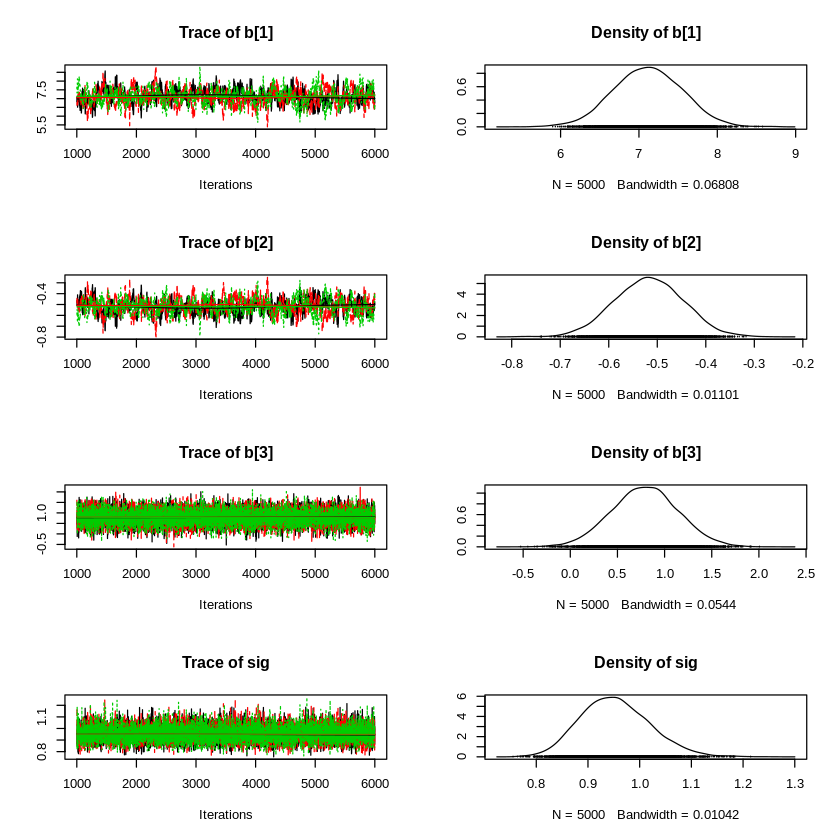

In [53]:
plot(mod2_sim)

In [54]:
gelman.diag(mod2_sim)

Potential scale reduction factors:

     Point est. Upper C.I.
b[1]       1.01       1.02
b[2]       1.01       1.02
b[3]       1.00       1.00
sig        1.00       1.00

Multivariate psrf

1

In [57]:
autocorr.diag(mod2_csim)

,b[1],b[2],b[3],sig
Lag 0,1.00000000,1.00000000,1.000000000,1.00000000
Lag 1,0.95232796,0.95274757,0.091976193,0.02989811
Lag 5,0.78291827,0.78312125,-0.014349208,0.00145516
Lag 10,0.61745801,0.61496930,0.008327639,0.02724337
Lag 50,0.07937087,0.07831813,-0.001890694,0.01627634


In [56]:
autocorr.diag(mod2_sim)

,b[1],b[2],b[3],sig
Lag 0,1.00000000,1.00000000,1.0000000000,1.0000000000
Lag 1,0.95155766,0.95194959,0.0918046323,0.0294539426
Lag 5,0.77939256,0.77968795,-0.0149733943,0.0007661611
Lag 10,0.61391309,0.61136294,0.0084417352,0.0263688103
Lag 50,0.07606268,0.07509375,-0.0004062618,0.0151962261


In [60]:
effectiveSize(mod2_sim)

b[1]       b[2]       b[3]        sig 
  372.3842   352.6104 12671.2772 13798.4590

In [61]:
summary(mod2_sim)


Iterations = 1001:6000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean      SD  Naive SE Time-series SE
b[1]  7.1145 0.43950 0.0035885      0.0230242
b[2] -0.5172 0.07110 0.0005805      0.0038002
b[3]  0.7909 0.35270 0.0028798      0.0031491
sig   0.9530 0.06726 0.0005492      0.0005739

2. Quantiles for each variable:

        2.5%     25%     50%     75%   97.5%
b[1]  6.2608  6.8169  7.1146  7.4150  7.9672
b[2] -0.6567 -0.5653 -0.5173 -0.4692 -0.3804
b[3]  0.1009  0.5546  0.7917  1.0252  1.4847
sig   0.8330  0.9058  0.9494  0.9964  1.0938


In [62]:
X2 = cbind(rep(1.0, data1_jags$n), data2_jags$log_income, data2_jags$is_oil)
head(X2)

1,8.139149,0
1,8.116716,0
1,8.115521,0
1,8.466110,0
1,8.522976,0
1,8.105308,0


In [63]:
(pm_params2 = colMeans(mod2_csim)) # posterior mean

b[1]       b[2]       b[3]        sig 
 7.1145042 -0.5172144  0.7908841  0.9530367

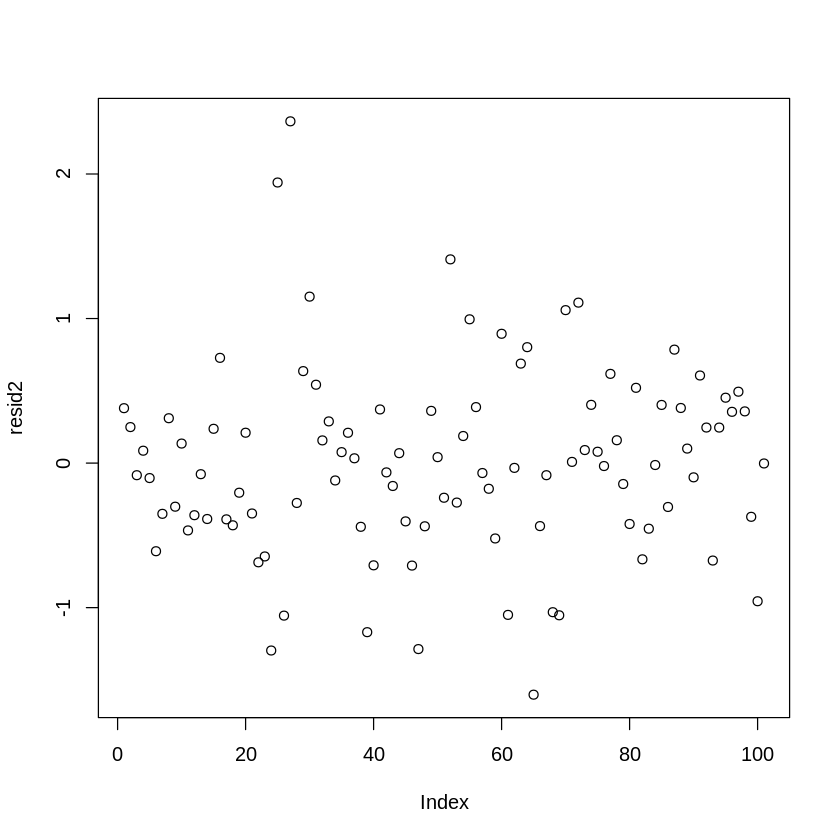

In [64]:
yhat2 = drop(X2 %*% pm_params2[1:3])
resid2 = data2_jags$y - yhat2
plot(resid2) # against data index

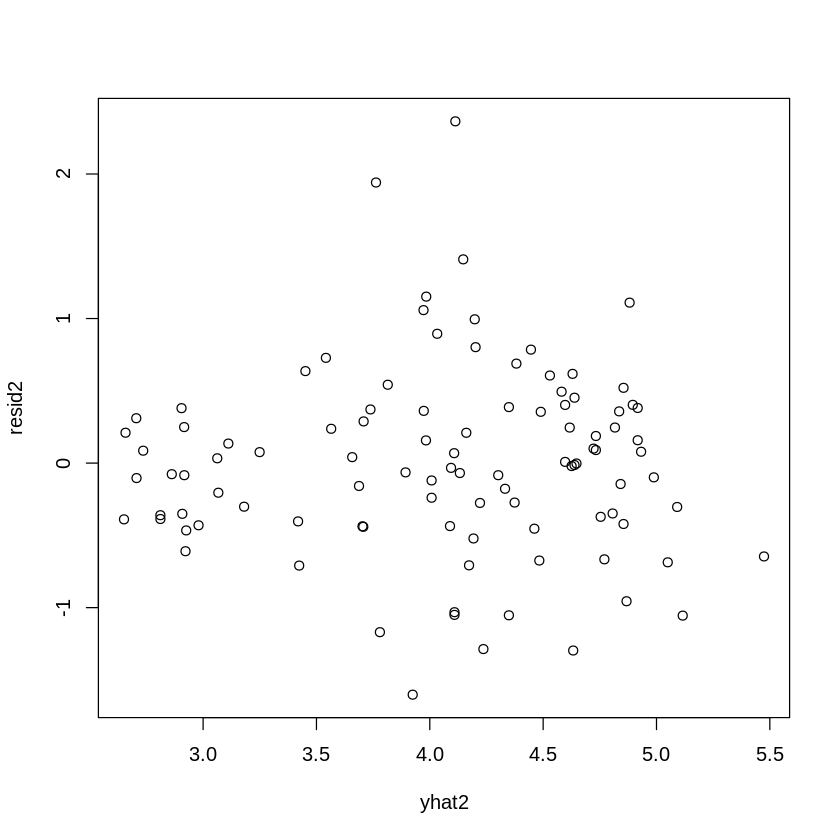

In [65]:
plot(yhat2, resid2) # against predicted values


## t-distribution

In [66]:
mod3_string = " model {
    for (i in 1:length(y)) {
        y[i] ~ dt( mu[i], tau, df )
        mu[i] = b[1] + b[2]*log_income[i] + b[3]*is_oil[i]
    }
    
    for (i in 1:3) {
        b[i] ~ dnorm(0.0, 1.0/1.0e6)
    }
    
    nu ~ dexp(1.0)    
    df = nu + 2.0 # we want degrees of freedom > 2 to guarantee existence of mean and variance
    tau ~ dgamma(5/2.0, 5*10.0/2.0) # tau is close to, but not equal to the precision
    sig = sqrt( 1.0 / tau * df / (df - 2.0) ) # standard deviation of errors
} "

set.seed(73)
data3_jags = list(y=dat$loginfant, log_income=dat$logincome,
                  is_oil=as.numeric(dat$oil=="yes"))

params3 = c("b")

inits3 = function() {
    inits = list("b"=rnorm(3,0.0,100.0))
}

mod3 = jags.model(textConnection(mod3_string), data=data3_jags, inits=inits3, n.chains=3)
update(mod3, 1e3) # burn-in

mod3_sim = coda.samples(model=mod3,
                        variable.names=params3,
                        n.iter=5e3)

mod3_csim = as.mcmc(do.call(rbind, mod3_sim)) # combine multiple chains

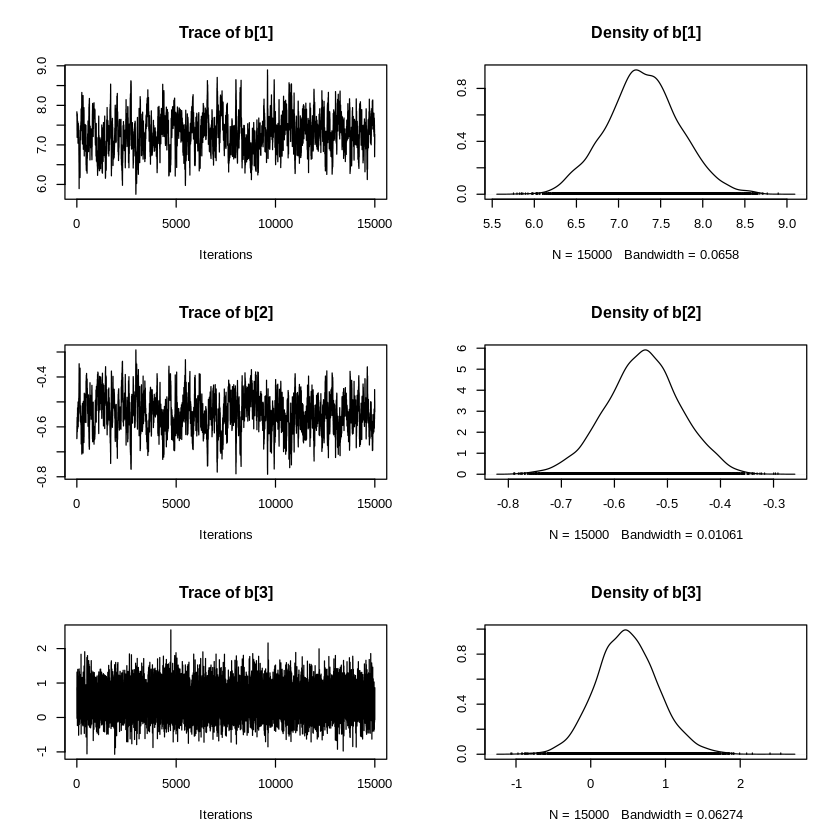

In [73]:
plot(mod3_csim)

summary(mod2_sim)

gelman.diag(mod3_sim)

In [86]:
X3 = cbind(rep(1.0, data1_jags$n), data2_jags$log_income, data2_jags$is_oil)
head(X3)

1,8.139149,0
1,8.116716,0
1,8.115521,0
1,8.466110,0
1,8.522976,0
1,8.105308,0


In [87]:
pm_params3 = colMeans(mod3_csim)
pm_params3

b[1]       b[2]       b[3] 
 7.2932052 -0.5457715  0.4889974

In [88]:
yhat3 = X3 %*% pm_params3
resid3 = data3_jags$y - yhat3

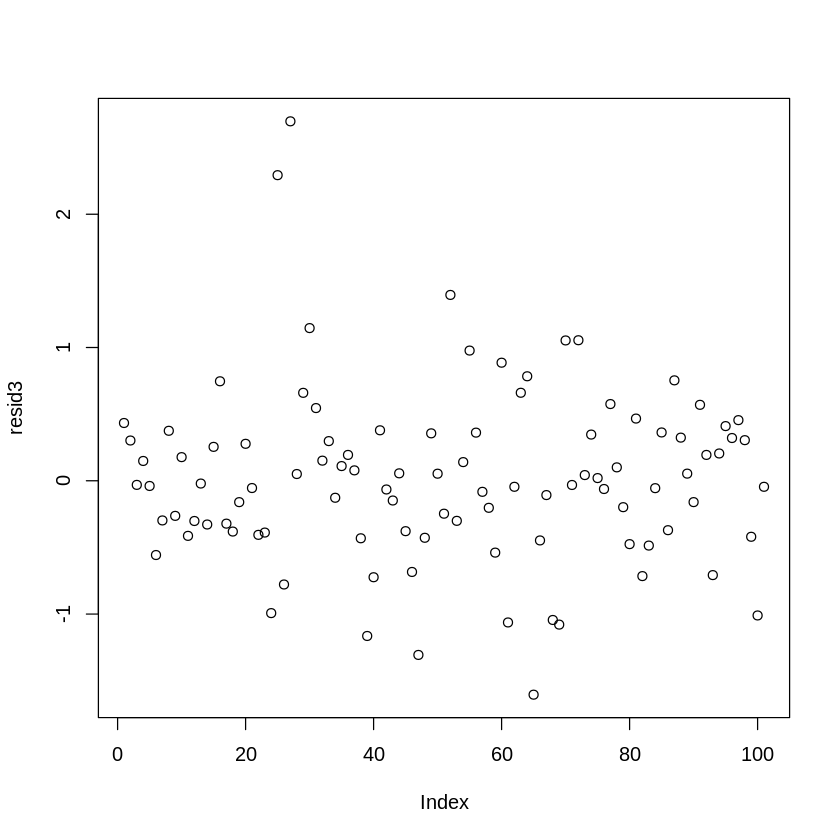

In [85]:
plot(resid3)

In [89]:
dic.samples(mod1,n.iter = 1e3)

Mean deviance:  231.6 
penalty 3 
Penalized deviance: 234.6 

In [90]:
dic.samples(mod2,n.iter = 1e3)

Mean deviance:  225.5 
penalty 4.281 
Penalized deviance: 229.8 

In [91]:
dic.samples(mod3,n.iter = 1e3)

Mean deviance:  230.7 
penalty 4.142 
Penalized deviance: 234.8 

## Assignments

,education,income,young,urban
ME,189,2824,350.7,508
NH,169,3259,345.9,564
VT,230,3072,348.5,322
MA,168,3835,335.3,846
RI,180,3549,327.1,871
CT,193,4256,341.0,774


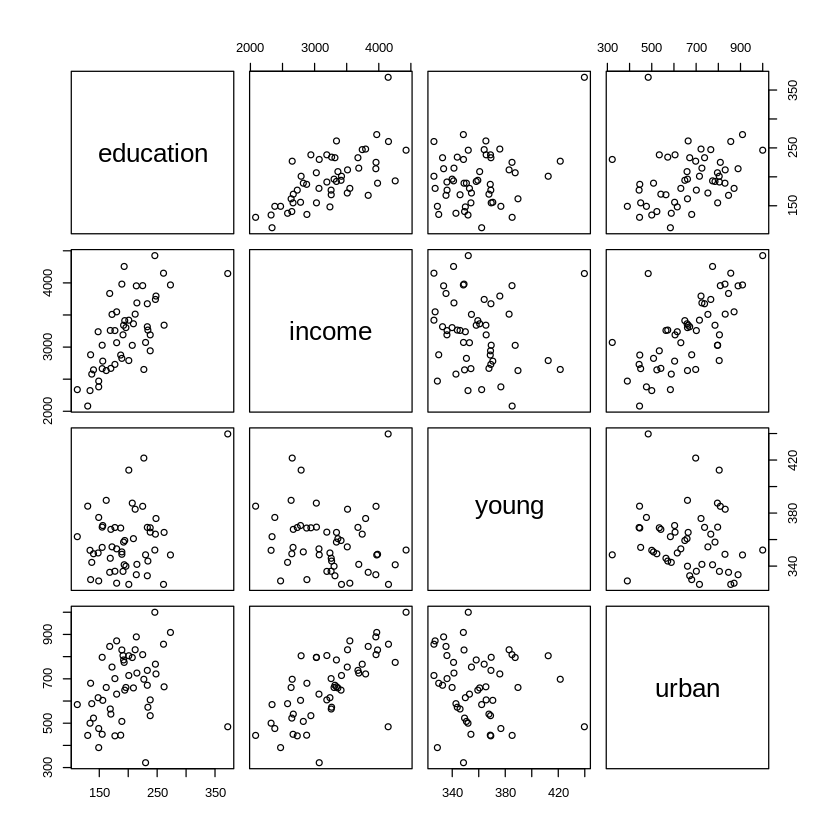

In [97]:
library("car")  # load the 'car' package
data("Anscombe")  # load the data set
?Anscombe  # read a description of the data
head(Anscombe) 
pairs(Anscombe)

In [126]:
lmod = lm(education ~ income + young + urban,data = Anscombe)
summary(lmod)


Call:
lm(formula = education ~ income + young + urban, data = Anscombe)

Residuals:
    Min      1Q  Median      3Q     Max 
-60.240 -15.738  -1.156  15.883  51.380 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.868e+02  6.492e+01  -4.418 5.82e-05 ***
income       8.065e-02  9.299e-03   8.674 2.56e-11 ***
young        8.173e-01  1.598e-01   5.115 5.69e-06 ***
urban       -1.058e-01  3.428e-02  -3.086  0.00339 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 26.69 on 47 degrees of freedom
Multiple R-squared:  0.6896,	Adjusted R-squared:  0.6698 
F-statistic: 34.81 on 3 and 47 DF,  p-value: 5.337e-12


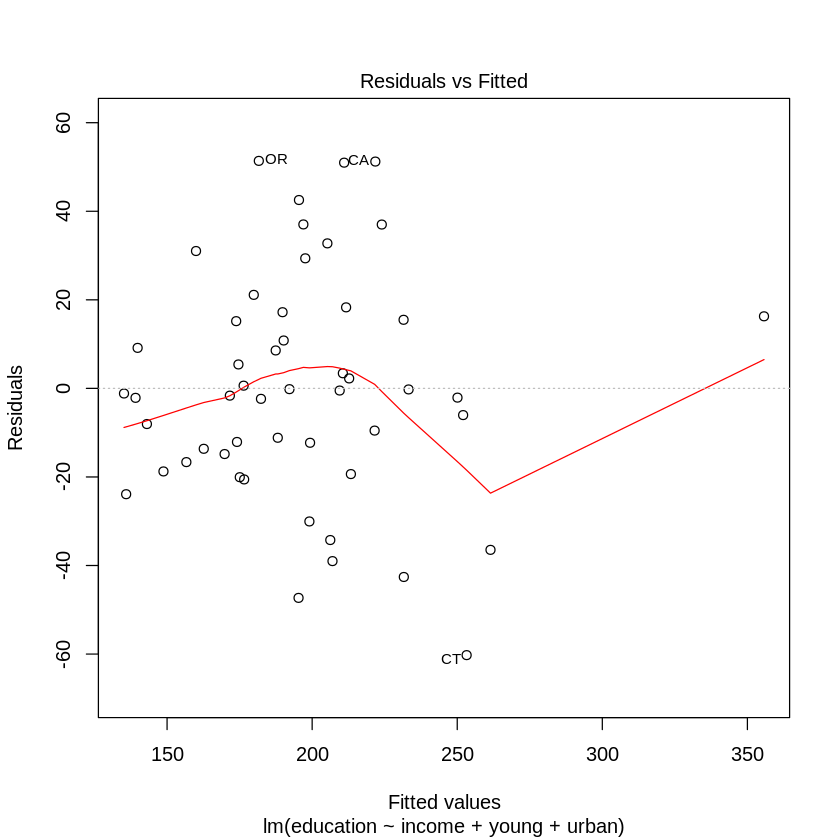

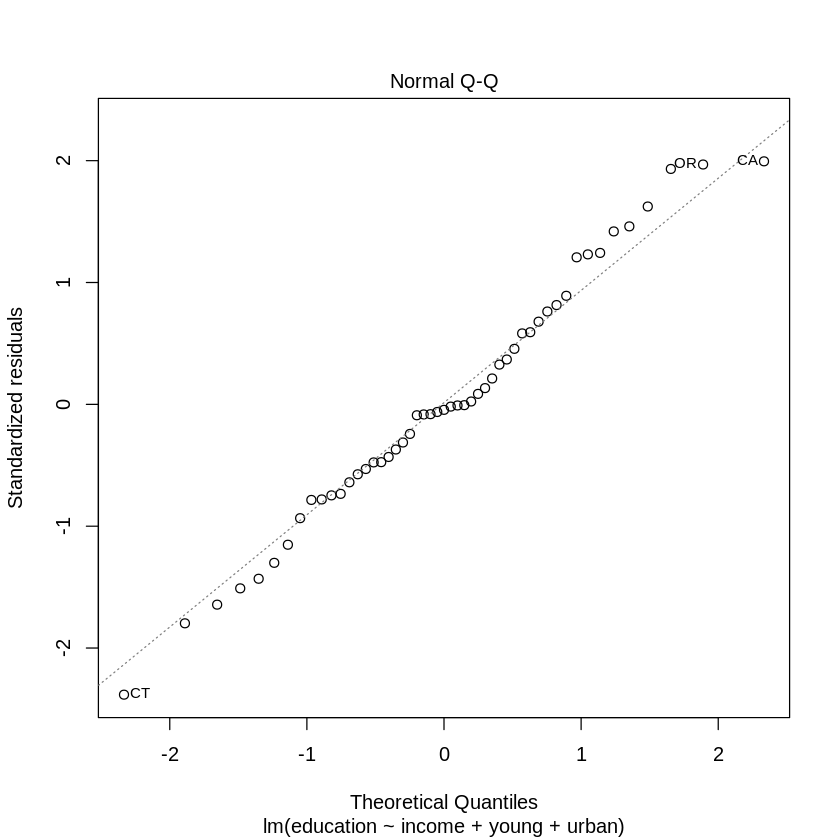

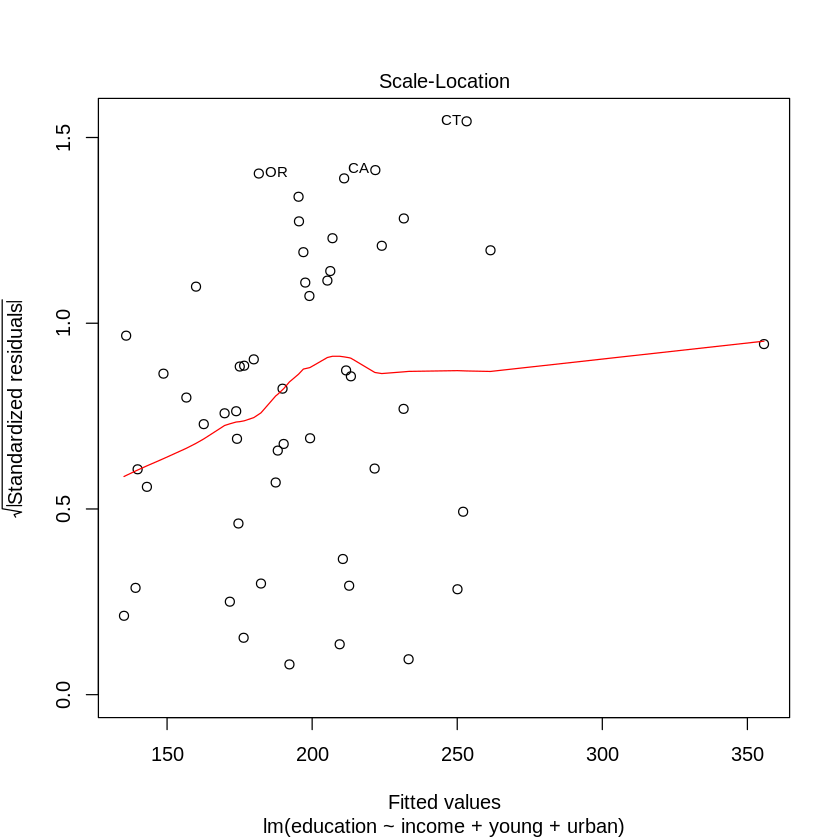

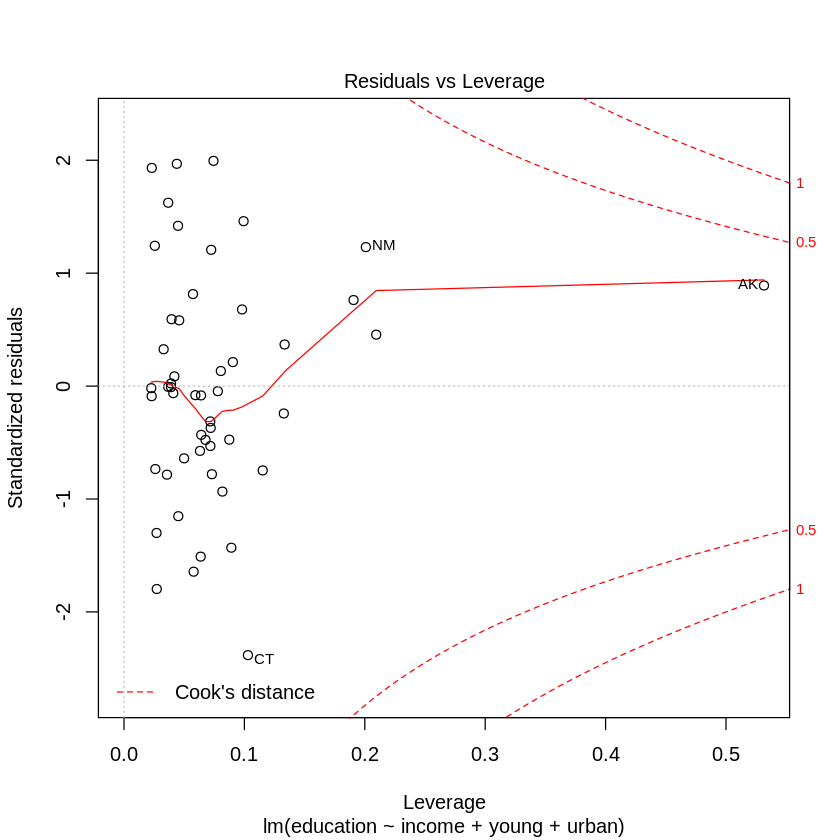

In [127]:
plot(lmod)

In [184]:
library("rjags")

mod_string = " model {
    for (i in 1:length(education)) {
        education[i] ~ dnorm(mu[i], prec)
        mu[i] = b0 + b[1]*income[i] + b[2]*young[i] + b[3]*urban[i]
    }
    
    b0 ~ dnorm(0.0, 1.0/1.0e6)
    for (i in 1:3) {
        b[i] ~ dnorm(0.0, 1.0/1.0e6)
    }
    
    prec ~ dgamma(1.0/2.0, 1.0*1500.0/2.0)
    ## Initial guess of variance based on overall
    ## variance of education variable. Uses low prior
    ## effective sample size. Technically, this is not
    ## a true 'prior', but it is not very informative.
    sig2 = 1.0 / prec
    sig = sqrt(sig2)
} "

data_jags = as.list(Anscombe)

params = c("b") # define model params to estimate 

inits = function() { # inits to get function 
    inits = list("b"=rnorm(3,0.0, 100.0))
}

mod = jags.model(textConnection(mod_string), data=data_jags, inits=inits, n.chains=3)
update(mod, 1e4) # burn-in
mod_sim = coda.samples(model=mod,variable.names=params,n.iter=1e5)
mod_csim = as.mcmc(do.call(rbind, mod_sim)) # combine multiple chains
dic.samples(mod, n.iter = 1e5)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 51
   Unobserved stochastic nodes: 5
   Total graph size: 436

Initializing model



Mean deviance:  481 
penalty 5.271 
Penalized deviance: 486.3 

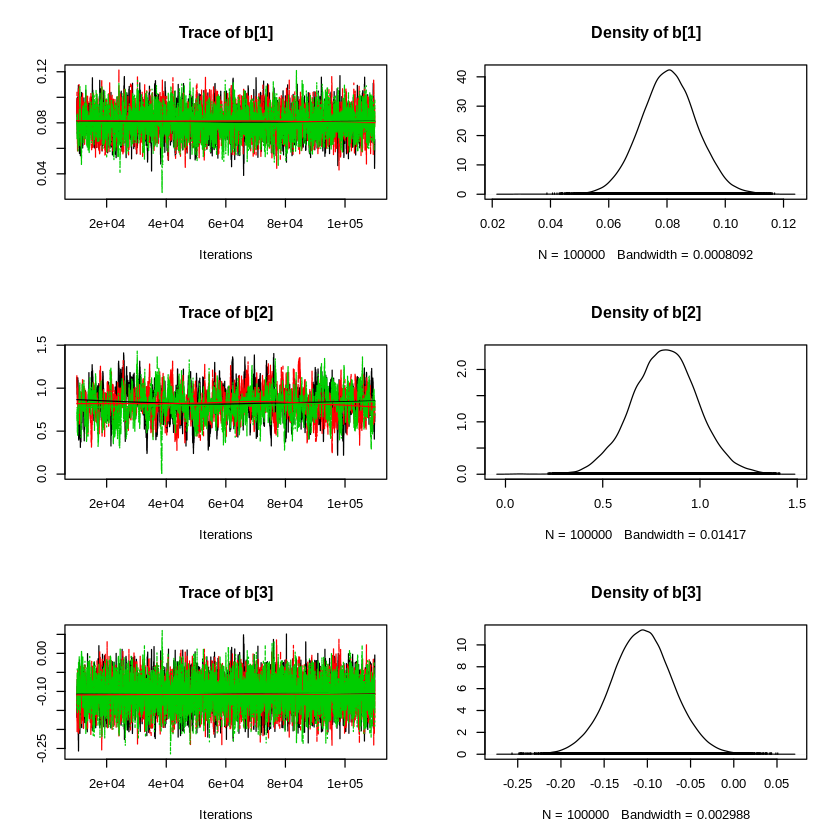

In [185]:
plot(mod_sim)

In [153]:
mod_csim['b']

[1] NA

In [166]:
typeof(mod_csim)

[1] "double"

In [183]:
colMeans(mod_csim)

b[1]        b[2]        b[3] 
 0.08028669  0.80699895 -0.10546461

In [182]:
mean(mod_sim[ ,3] > 0)

ERROR: Error in mean(mod_sim[, 3] > 0): (list) object cannot be coerced to type 'double'


In [138]:
library("rjags")

mod1_string = " model {
    for (i in 1:length(education)) {
        education[i] ~ dnorm(mu[i], prec)
        mu[i] = b0 + b[1]*income[i] + b[2]*young[i]
    }
    
    b0 ~ dnorm(0.0, 1.0/1.0e6)
    for (i in 1:2) {
        b[i] ~ dnorm(0.0, 1.0/1.0e6)
    }
    
    prec ~ dgamma(1.0/2.0, 1.0*1500.0/2.0)
    ## Initial guess of variance based on overall
    ## variance of education variable. Uses low prior
    ## effective sample size. Technically, this is not
    ## a true 'prior', but it is not very informative.
    sig2 = 1.0 / prec
    sig = sqrt(sig2)
} "

data_jags = as.list(Anscombe)

params = c("b") # define model params to estimate 

inits = function() { # inits to get function 
    inits = list("b"=rnorm(2,0.0, 100.0))
}

mod1 = jags.model(textConnection(mod1_string), data=data_jags, inits=inits, n.chains=3)
update(mod1, 1e4) # burn-in
dic.samples(mod1, n.iter = 1e5)
#mod1_sim = coda.samples(model=mod1,variable.names=params,n.iter=1e5)
#mod1_csim = as.mcmc(do.call(rbind, mod2_sim)) # combine multiple chains

Warning message in jags.model(textConnection(mod1_string), data = data_jags, inits = inits, :
“Unused variable "urban" in data”

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 51
   Unobserved stochastic nodes: 4
   Total graph size: 331

Initializing model



Mean deviance:  489.1 
penalty 4.056 
Penalized deviance: 493.2 

In [139]:
library("rjags")

mod2_string = " model {
    for (i in 1:length(education)) {
        education[i] ~ dnorm(mu[i], prec)
        mu[i] = b0 + b[1]*income[i] + b[2]*young[i] + b[3]*income[i]*young[i]
    }
    
    b0 ~ dnorm(0.0, 1.0/1.0e6)
    for (i in 1:3) {
        b[i] ~ dnorm(0.0, 1.0/1.0e6)
    }
    
    prec ~ dgamma(1.0/2.0, 1.0*1500.0/2.0)
    ## Initial guess of variance based on overall
    ## variance of education variable. Uses low prior
    ## effective sample size. Technically, this is not
    ## a true 'prior', but it is not very informative.
    sig2 = 1.0 / prec
    sig = sqrt(sig2)
} "

data_jags = as.list(Anscombe)

params = c("b") # define model params to estimate 

inits = function() { # inits to get function 
    inits = list("b"=rnorm(3,0.0, 100.0))
}

mod2 = jags.model(textConnection(mod2_string), data=data_jags, inits=inits, n.chains=3)
update(mod2, 1e4) # burn-in
dic.samples(mod2, n.iter = 1e5)
#mod1_sim = coda.samples(model=mod1,variable.names=params,n.iter=1e5)
#mod1_csim = as.mcmc(do.call(rbind, mod2_sim)) # combine multiple chains

Warning message in jags.model(textConnection(mod2_string), data = data_jags, inits = inits, :
“Unused variable "urban" in data”

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 51
   Unobserved stochastic nodes: 5
   Total graph size: 386

Initializing model



Mean deviance:  487.5 
penalty 5.468 
Penalized deviance: 492.9 

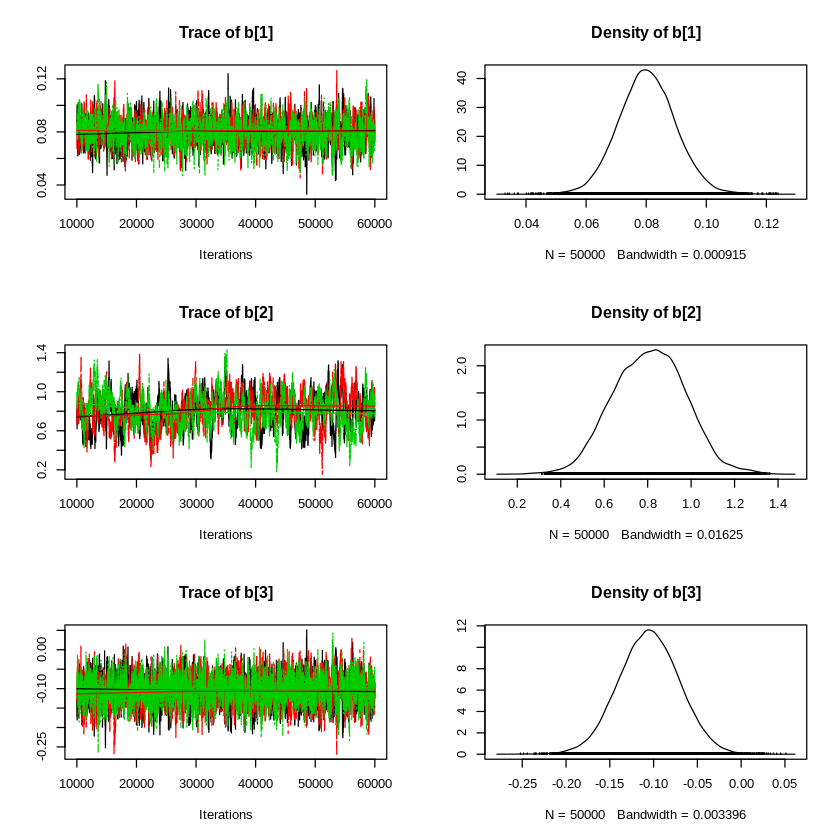

In [125]:
plot(mod_sim)

### 1. Check gelman convergence

In [119]:
gelman.diag(mod_sim) # above 1., looks good

Potential scale reduction factors:

     Point est. Upper C.I.
b[1]       1.00       1.01
b[2]       1.01       1.02
b[3]       1.00       1.01

Multivariate psrf

1.01

### 2. Check effective size and acf

In [120]:
effectiveSize(mod_sim)

b[1]      b[2]      b[3] 
 980.5506  237.3307 1401.9842

In [121]:
autocorr.diag(mod_sim) # very strong acf

,b[1],b[2],b[3]
Lag 0,1.0000000,1.0000000,1.0000000
Lag 1,0.9852742,0.9958153,0.9740555
Lag 5,0.9304481,0.9804193,0.8818403
Lag 10,0.8700201,0.9632945,0.7898502
Lag 50,0.5424969,0.8557237,0.4211354


In [130]:
dic.samples(mod,n.iter = 1e3)

Mean deviance:  480.4 
penalty 4.479 
Penalized deviance: 484.9 